In [ ]:
from IPython.display import clear_output

!pip install torch
!pip install qiskit
!pip install qiskit_algorithms
!pip install qiskit_machine_learning
!pip install pylatexenc

clear_output()

In [ ]:
# Necessary imports

import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.circuit.library import QNNCircuit

# Set seed for random generators
algorithm_globals.random_seed = 42

In [ ]:
import pandas as pd

train = pd.read_csv('/content/sample_data/Train.csv')
test = pd.read_csv('/content/sample_data/Test.csv')
all = pd.concat([train, test], ignore_index = True)

In [ ]:
print(train.shape)
print(test.shape)
print(all.shape)

(1763, 1559)
(756, 1558)
(2519, 1559)


In [ ]:
X = train.drop("Class", axis = 1)
y = train["Class"]
y = 2*y - 1

In [ ]:
X.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_1549,feature_1550,feature_1551,feature_1552,feature_1553,feature_1554,feature_1555,feature_1556,feature_1557,feature_1558
0,100,160,1.6000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,20,83,4.1500,1,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,99,150,1.5151,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,40,40,1.0000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12,234,19.5000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
y.head()

0   -1
1   -1
2   -1
3   -1
4   -1
Name: Class, dtype: int64

In [ ]:
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()
scaled_data = pd.DataFrame(scalar.fit_transform(X)) #scaling the data

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 3)
pca.fit(scaled_data)
X_pca = pca.transform(scaled_data)
X_pca = pd.DataFrame(X_pca,columns=['PC1','PC2','PC3'])
X_pca

,PC1,PC2,PC3
0,-0.557764,-0.710592,-0.314474
1,0.844616,2.754518,45.162700
2,-0.596832,-0.791612,-0.389834
3,-0.594097,-0.637186,-0.186503
4,-0.232868,-0.547337,-0.047295
...,...,...,...
1758,-0.634638,-0.853075,-0.295411
1759,-0.398647,-0.840052,-0.347482
1760,-0.143853,-0.509543,-0.204879
1761,-0.558422,-0.728312,-0.244949


<Axes: >

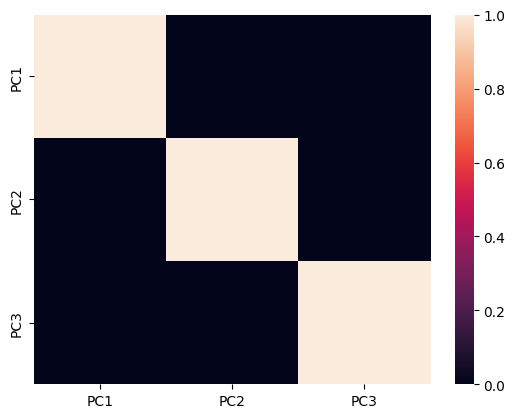

In [ ]:
import seaborn as sns

sns.heatmap(X_pca.corr())

<Axes: >

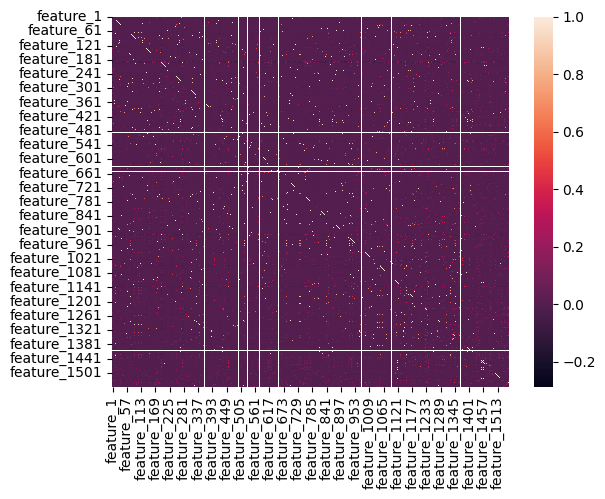

In [ ]:
sns.heatmap(X.corr())

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(X_pca, y, test_size = 0.1, stratify = y)

/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


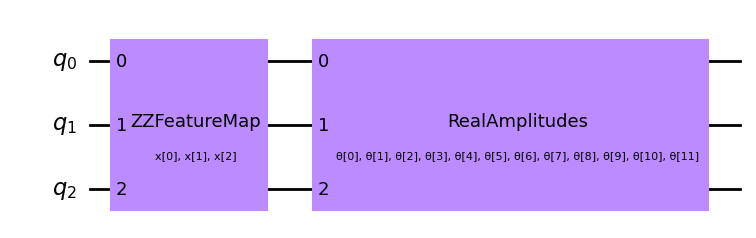

In [ ]:
qc = QNNCircuit(num_qubits=3)
qc.draw(output="mpl")

In [ ]:
estimator_qnn = EstimatorQNN(circuit=qc)

In [ ]:
# QNN maps inputs to [-1, +1]
estimator_qnn.forward(X_pca, algorithm_globals.random.random(estimator_qnn.num_weights))

array([[-0.32208159],
       [ 0.04363601],
       [ 0.26841169],
       ...,
       [ 0.57180923],
       [-0.51275515],
       [ 0.27006861]])

In [ ]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [ ]:
# construct neural network classifier
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B

In [ ]:
# construct neural network classifier
estimator_classifier = NeuralNetworkClassifier(
    estimator_qnn, optimizer=COBYLA(maxiter=60), callback=callback_graph
)

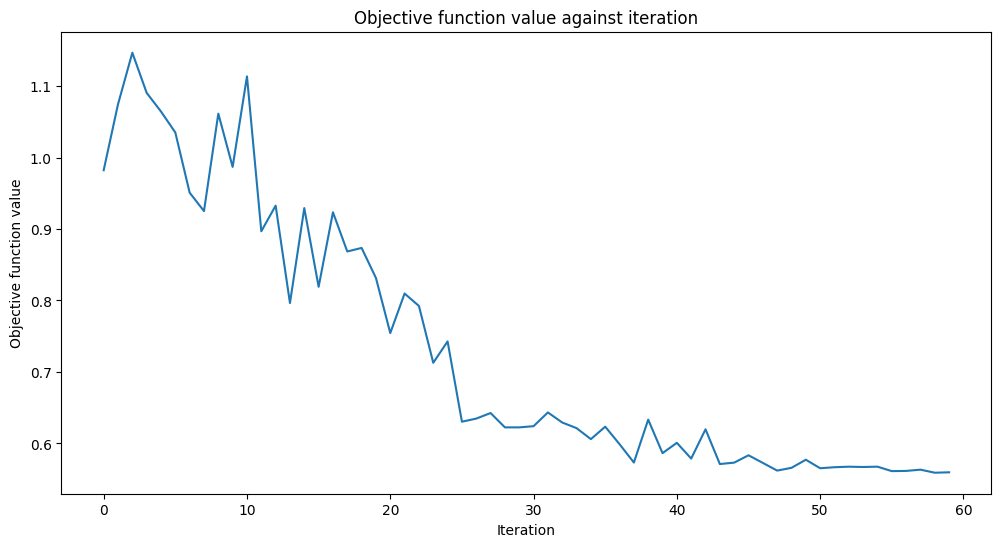

0.8259773013871374

In [ ]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
estimator_classifier.fit(x_train, y_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
estimator_classifier.score(x_train, y_train)

In [ ]:
# evaluate data points
y_pred = estimator_classifier.predict(x_valid)

In [ ]:
y_valid = np.asarray(y_valid)

score = 0

for i in range(len(y_pred)):
  if y_pred[i] == y_valid[i]:
    score += 1

accuracy = (score/len(y_valid))*100
print(accuracy)

81.92090395480226
